In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import json
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import difflib
import pprint
from sklearn.utils import resample

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
customFig = (10,8)


/Users/xavier/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('data/nyc_inspection_results.csv')

In [3]:
df.columns = map(str.lower, df.columns)

In [4]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]

In [5]:
df['zipcode'] = df.zipcode.astype(str)

In [6]:
df['zipcode'] = df['zipcode'].str.slice(0,5)

In [ ]:
df.cuisine_description.replace()

In [8]:
df['inspection_date'].max()

'12/31/2016'

In [9]:
df['inspection_date'].min()

'01/01/1900'

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399918 entries, 0 to 399917
Data columns (total 18 columns):
camis                    399918 non-null int64
dba                      399559 non-null object
boro                     399918 non-null object
building                 399809 non-null object
street                   399909 non-null object
zipcode                  399918 non-null object
phone                    399913 non-null object
cuisine_description      399918 non-null object
inspection_date          399918 non-null object
action                   398783 non-null object
violation_code           393414 non-null object
violation_description    392939 non-null object
critical_flag            399918 non-null object
score                    376704 non-null float64
grade                    195413 non-null object
grade_date               192820 non-null object
record_date              399918 non-null object
inspection_type          398783 non-null object
dtypes: float64(1), int64

In [11]:
df['inspection_date'] = pd.to_datetime(df.inspection_date)
df['grade_date'] = pd.to_datetime(df.grade_date)
df['record_date'] = pd.to_datetime(df.record_date)

In [12]:
start_date = '01/01/2014'
end_date = '12/31/2016'
mask = (df['inspection_date'] > start_date) & (df['inspection_date'] <= end_date)

In [13]:
df = df[mask]

In [14]:
df.shape

(313983, 18)

In [15]:
df.violation_code.isnull().sum()

4572

In [16]:
df.dropna(subset=['violation_code'],axis=0,inplace=True)

In [17]:
vermin_codes = ['04K','04L','04M','04N','08A']
contamination_codes = ['04H','06B','06C','06D','08C']
facility_codes = ['10A','10B','10D','10E','10F','10H','15L','22A','22C']
food_handling_codes = ['03A','03C','09A','09B','09C']
hygiene_codes = ['04D','04F','06A','06E','06F','08B','10I']
regulatory_codes = ['04A','16B','20D','20F']
temperature_codes = ['02B','02G','02H','05F']

In [18]:
d = {'vermin':vermin_codes,'contamination':contamination_codes,
            'facility':facility_codes,'food_handling':food_handling_codes,
            'hygiene':hygiene_codes,'regulatory':regulatory_codes,
            'temperature':temperature_codes}

In [19]:
def violations(row,d):
    for k,v in d.items():
        if row['violation_code'] in v:
            return k
    

In [20]:
df['violations'] = df.apply(lambda x: violations(x,d),axis=1)

In [21]:
df.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,violations
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016,2126863400,Italian,2015-06-15,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaT,2017-08-28,Cycle Inspection / Initial Inspection,temperature
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016,2126863400,Italian,2014-11-25,Violations were cited in the following area(s).,20F,Current letter grade card not posted.,Not Critical,NaN,NaN,NaT,2017-08-28,Administrative Miscellaneous / Initial Inspection,regulatory
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106,3478134702,Italian,2016-10-03,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaT,2017-08-28,Pre-permit (Operational) / Initial Inspection,facility
5,50015855,KABAB HOUSE NYC,QUEENS,4339,MAIN ST,11355,9172852796,Pakistani,2015-03-03,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,19.0,NaN,NaT,2017-08-28,Pre-permit (Operational) / Compliance Inspection,facility
8,41547684,PLANET WINGS,STATEN ISLAND,480,FOREST AVENUE,10310,7187209464,American,2015-03-10,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,28.0,NaN,NaT,2017-08-28,Cycle Inspection / Initial Inspection,temperature


In [22]:
df.drop(['violation_code','violation_description','action'],axis=1,inplace=True)

In [23]:
df.inspection_type.unique()

array(['Cycle Inspection / Initial Inspection',
       'Administrative Miscellaneous / Initial Inspection',
       'Pre-permit (Operational) / Initial Inspection',
       'Pre-permit (Operational) / Compliance Inspection',
       'Cycle Inspection / Re-inspection',
       'Cycle Inspection / Compliance Inspection',
       'Trans Fat / Initial Inspection',
       'Administrative Miscellaneous / Reopening Inspection',
       'Smoke-Free Air Act / Re-inspection',
       'Administrative Miscellaneous / Re-inspection',
       'Smoke-Free Air Act / Initial Inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Cycle Inspection / Reopening Inspection',
       'Pre-permit (Non-operational) / Re-inspection',
       'Pre-permit (Non-operational) / Initial Inspection',
       'Inter-Agency Task Force / Initial Inspection',
       'Trans Fat / Re-inspection', 'Calorie Posting / Initial Inspection',
       'Calorie Posting / Re-inspection',
       'Administrative Miscellaneous / Co

In [24]:
df.cuisine_description.unique()

array(['Italian', 'Pakistani', 'American', 'Japanese', 'Caribbean',
       'Seafood', 'Chinese', 'Pizza', 'Indian', 'Soul Food',
       'Bagels/Pretzels', 'Steak', 'Tapas', 'Chinese/Japanese',
       'Vegetarian', 'Mexican', 'Turkish', 'Spanish', 'CafÃ©/Coffee/Tea',
       'Greek', 'Hamburgers', 'Bakery',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Continental', 'Brazilian', 'Mediterranean', 'Thai', 'Donuts',
       'Delicatessen', 'Jewish/Kosher', 'Sandwiches', 'Russian',
       'Vietnamese/Cambodian/Malaysia', 'Sandwiches/Salads/Mixed Buffet',
       'Tex-Mex',
       'Bottled beverages, including water, sodas, juices, etc.', 'Irish',
       'Korean', 'French', 'Ice Cream, Gelato, Yogurt, Ices',
       'Middle Eastern', 'Asian', 'Juice, Smoothies, Fruit Salads',
       'Pizza/Italian', 'Chicken', 'Australian', 'Bangladeshi', 'African',
       'Peruvian', 'Creole', 'Hotdogs', 'Hotdogs/Pretzels', 'English',
       'German', 'Hawaiian', 'Pancakes/W

In [25]:
gradeMask = (df['grade'] == 'A') | (df['grade'] == 'B') | (df['grade']== 'C')
gradeDF = df[gradeMask]

In [26]:
gradeDF.shape

(150893, 16)

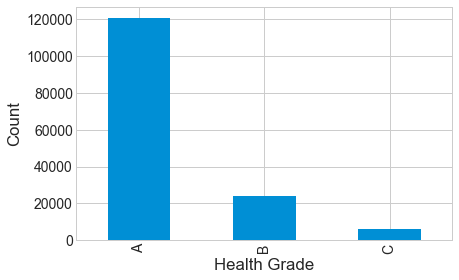

In [27]:
gradeGroup = gradeDF.groupby('grade').grade.count()
gradeGroup.plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Health Grade")

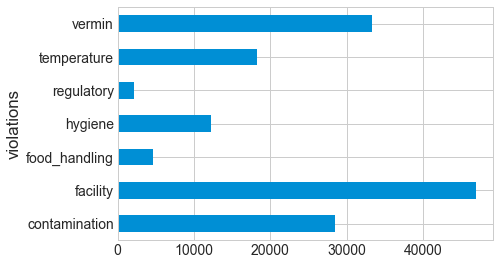

In [28]:
violationGroup = gradeDF.groupby('violations').violations.count()
violationGroup.plot(kind='barh')


In [29]:
gradeDF.shape

(150893, 16)

In [30]:
gradeGroup

grade
A    120770
B     24079
C      6044
Name: grade, dtype: int64

In [31]:
df = gradeDF

In [32]:
df['inspection_year'] = df.inspection_date.dt.year 

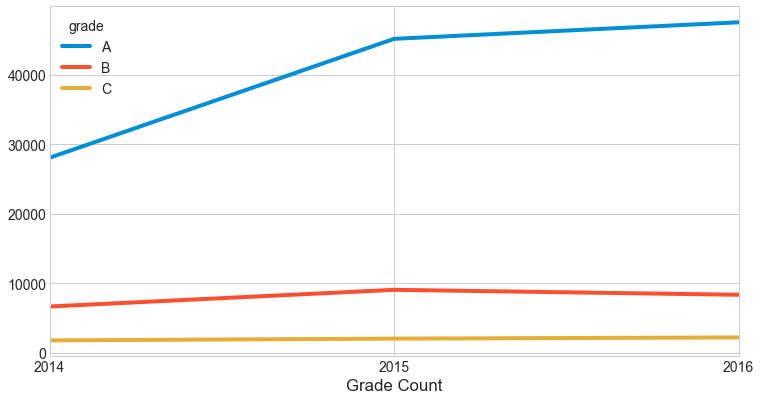

In [38]:
gradeYearGroup = df.groupby(['inspection_year','grade']).camis.count().reset_index()
year_ticks = ('2014','2015','2016')
#entry_ticks = (200,300,400)
plot_out = gradeYearGroup.pivot('inspection_year','grade','camis').plot(kind='line',figsize=(11,6))
plt.xticks(range(2014,2017),year_ticks)
plt.xlabel("Inspection Year")
plt.xlabel("Grade Count")

### Prepare to match with Yelp

In [7]:
# df.boro.replace("MANHATTAN","NEW YORK",inplace=True)

In [39]:
df['address'] = df.building + ' ' + df.street + ' ' + df.boro + ' ' + df.zipcode

In [40]:
df.columns.tolist()

['camis',
 'dba',
 'boro',
 'building',
 'street',
 'zipcode',
 'phone',
 'cuisine_description',
 'inspection_date',
 'critical_flag',
 'score',
 'grade',
 'grade_date',
 'record_date',
 'inspection_type',
 'violations',
 'inspection_year',
 'address']

In [41]:
df.dropna(subset=['dba','zipcode'],inplace=True,axis=0)

In [42]:
df.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,critical_flag,score,grade,grade_date,record_date,inspection_type,violations,inspection_year,address
9,40376944,TOMOE SUSHI,MANHATTAN,172,THOMPSON STREET,10012,2127779346,Japanese,2015-10-06,Critical,13.0,A,2015-10-06,2017-08-28,Cycle Inspection / Re-inspection,temperature,2015,172 THOMPSON STREET MANHATTAN 10012
12,41701178,CRAB SPOT RESTAURANT,BROOKLYN,833,UNION STREET,11215,7186222722,Seafood,2016-07-28,Not Critical,12.0,A,2016-07-28,2017-08-28,Cycle Inspection / Initial Inspection,food_handling,2016,833 UNION STREET BROOKLYN 11215
16,41552184,NOM WAH TEA/DIM SUM PALOR,MANHATTAN,13,DOYERS STREET,10013,2129626047,Chinese,2014-09-02,Critical,18.0,B,2014-09-02,2017-08-28,Cycle Inspection / Re-inspection,temperature,2014,13 DOYERS STREET MANHATTAN 10013
17,41696159,LUIGI'S PIZZA & PASTA,BRONX,119,EAST MOUNT EDEN AVENUE,10452,7182941800,Pizza,2014-10-27,Not Critical,13.0,A,2014-10-27,2017-08-28,Cycle Inspection / Re-inspection,facility,2014,119 EAST MOUNT EDEN AVENUE BRONX 10452
22,41611667,SERVICE BAR 7,QUEENS,11000,ROCKAWAY BOULEVARD,11420,6465881074,American,2016-04-07,Not Critical,7.0,A,2016-04-07,2017-08-28,Cycle Inspection / Initial Inspection,facility,2016,11000 ROCKAWAY BOULEVARD QUEENS 11420


In [43]:
uniqueDF = df

In [44]:
uniqueDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150893 entries, 9 to 399917
Data columns (total 18 columns):
camis                  150893 non-null int64
dba                    150893 non-null object
boro                   150893 non-null object
building               150850 non-null object
street                 150893 non-null object
zipcode                150893 non-null object
phone                  150893 non-null object
cuisine_description    150893 non-null object
inspection_date        150893 non-null datetime64[ns]
critical_flag          150893 non-null object
score                  150891 non-null float64
grade                  150893 non-null object
grade_date             150893 non-null datetime64[ns]
record_date            150893 non-null datetime64[ns]
inspection_type        150893 non-null object
violations             146126 non-null object
inspection_year        150893 non-null int64
address                150850 non-null object
dtypes: datetime64[ns](3), float64(1),

In [45]:
uniqueDF.grade.isnull().sum()

0

In [46]:
uniqueDF.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,critical_flag,score,grade,grade_date,record_date,inspection_type,violations,inspection_year,address
9,40376944,TOMOE SUSHI,MANHATTAN,172,THOMPSON STREET,10012,2127779346,Japanese,2015-10-06,Critical,13.0,A,2015-10-06,2017-08-28,Cycle Inspection / Re-inspection,temperature,2015,172 THOMPSON STREET MANHATTAN 10012
12,41701178,CRAB SPOT RESTAURANT,BROOKLYN,833,UNION STREET,11215,7186222722,Seafood,2016-07-28,Not Critical,12.0,A,2016-07-28,2017-08-28,Cycle Inspection / Initial Inspection,food_handling,2016,833 UNION STREET BROOKLYN 11215
16,41552184,NOM WAH TEA/DIM SUM PALOR,MANHATTAN,13,DOYERS STREET,10013,2129626047,Chinese,2014-09-02,Critical,18.0,B,2014-09-02,2017-08-28,Cycle Inspection / Re-inspection,temperature,2014,13 DOYERS STREET MANHATTAN 10013
17,41696159,LUIGI'S PIZZA & PASTA,BRONX,119,EAST MOUNT EDEN AVENUE,10452,7182941800,Pizza,2014-10-27,Not Critical,13.0,A,2014-10-27,2017-08-28,Cycle Inspection / Re-inspection,facility,2014,119 EAST MOUNT EDEN AVENUE BRONX 10452
22,41611667,SERVICE BAR 7,QUEENS,11000,ROCKAWAY BOULEVARD,11420,6465881074,American,2016-04-07,Not Critical,7.0,A,2016-04-07,2017-08-28,Cycle Inspection / Initial Inspection,facility,2016,11000 ROCKAWAY BOULEVARD QUEENS 11420


In [47]:
uniqueDF.shape

(150893, 18)

In [48]:
dupes = ['dba','address']

In [49]:
df2 = uniqueDF.drop_duplicates(subset=dupes,keep='first')

In [50]:
df2.shape

(22325, 18)

In [51]:
df2.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,critical_flag,score,grade,grade_date,record_date,inspection_type,violations,inspection_year,address
9,40376944,TOMOE SUSHI,MANHATTAN,172,THOMPSON STREET,10012,2127779346,Japanese,2015-10-06,Critical,13.0,A,2015-10-06,2017-08-28,Cycle Inspection / Re-inspection,temperature,2015,172 THOMPSON STREET MANHATTAN 10012
12,41701178,CRAB SPOT RESTAURANT,BROOKLYN,833,UNION STREET,11215,7186222722,Seafood,2016-07-28,Not Critical,12.0,A,2016-07-28,2017-08-28,Cycle Inspection / Initial Inspection,food_handling,2016,833 UNION STREET BROOKLYN 11215
16,41552184,NOM WAH TEA/DIM SUM PALOR,MANHATTAN,13,DOYERS STREET,10013,2129626047,Chinese,2014-09-02,Critical,18.0,B,2014-09-02,2017-08-28,Cycle Inspection / Re-inspection,temperature,2014,13 DOYERS STREET MANHATTAN 10013
17,41696159,LUIGI'S PIZZA & PASTA,BRONX,119,EAST MOUNT EDEN AVENUE,10452,7182941800,Pizza,2014-10-27,Not Critical,13.0,A,2014-10-27,2017-08-28,Cycle Inspection / Re-inspection,facility,2014,119 EAST MOUNT EDEN AVENUE BRONX 10452
22,41611667,SERVICE BAR 7,QUEENS,11000,ROCKAWAY BOULEVARD,11420,6465881074,American,2016-04-07,Not Critical,7.0,A,2016-04-07,2017-08-28,Cycle Inspection / Initial Inspection,facility,2016,11000 ROCKAWAY BOULEVARD QUEENS 11420


In [52]:
df2.dropna(subset=['address'],inplace=True,axis=0)

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
df2.shape

(22316, 18)

In [54]:
df2.rename(columns={'dba':'name'},inplace=True)

/Users/xavier/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [55]:
df2.head()

,camis,name,boro,building,street,zipcode,phone,cuisine_description,inspection_date,critical_flag,score,grade,grade_date,record_date,inspection_type,violations,inspection_year,address
9,40376944,TOMOE SUSHI,MANHATTAN,172,THOMPSON STREET,10012,2127779346,Japanese,2015-10-06,Critical,13.0,A,2015-10-06,2017-08-28,Cycle Inspection / Re-inspection,temperature,2015,172 THOMPSON STREET MANHATTAN 10012
12,41701178,CRAB SPOT RESTAURANT,BROOKLYN,833,UNION STREET,11215,7186222722,Seafood,2016-07-28,Not Critical,12.0,A,2016-07-28,2017-08-28,Cycle Inspection / Initial Inspection,food_handling,2016,833 UNION STREET BROOKLYN 11215
16,41552184,NOM WAH TEA/DIM SUM PALOR,MANHATTAN,13,DOYERS STREET,10013,2129626047,Chinese,2014-09-02,Critical,18.0,B,2014-09-02,2017-08-28,Cycle Inspection / Re-inspection,temperature,2014,13 DOYERS STREET MANHATTAN 10013
17,41696159,LUIGI'S PIZZA & PASTA,BRONX,119,EAST MOUNT EDEN AVENUE,10452,7182941800,Pizza,2014-10-27,Not Critical,13.0,A,2014-10-27,2017-08-28,Cycle Inspection / Re-inspection,facility,2014,119 EAST MOUNT EDEN AVENUE BRONX 10452
22,41611667,SERVICE BAR 7,QUEENS,11000,ROCKAWAY BOULEVARD,11420,6465881074,American,2016-04-07,Not Critical,7.0,A,2016-04-07,2017-08-28,Cycle Inspection / Initial Inspection,facility,2016,11000 ROCKAWAY BOULEVARD QUEENS 11420


In [56]:
uniqueDF = df2

In [57]:
uniqueDF.grade.isnull().sum()

0

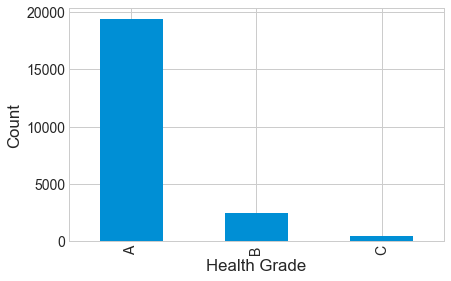

In [58]:
gradeGroup = uniqueDF.groupby('grade').grade.count()
gradeGroup.plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Health Grade")

In [59]:
uniqueDF.groupby('grade').name.nunique()

grade
A    15460
B     2286
C      475
Name: name, dtype: int64

In [66]:
cuisineGroup = uniqueDF.groupby('cuisine_description').grade.count().reset_index()
cuisineGroup.sort_values('grade',ascending=False,inplace=True)
cuisineGroup.head()

,cuisine_description,grade
2,American,5485
18,Chinese,2062
12,CafÃ©/Coffee/Tea,1307
61,Pizza,1036
45,Italian,953


In [60]:
cuisineDF = uniqueDF.cuisine_description.str.get_dummies()

In [61]:
cuisineDF.head()

,Afghan,African,American,Armenian,Asian,Australian,Bagels/Pretzels,Bakery,Bangladeshi,Barbecue,...,Soups & Sandwiches,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
uniqueDF = uniqueDF.join(cuisineDF)

In [130]:
uniqueDF.to_pickle('data/inspection.pkl')

## Yelp Data

In [131]:
data = []
with open('data/yelp_restaurants.json') as f:
    for line in f:
        data.append(json.loads(line))
    
yelpDF = pd.io.json.json_normalize(data)

In [132]:
yelpDF.head()

,business_id,business_name,categories,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.display_address,location.state,location.zip_code,price,rating,review_count
0,notaro-ristorante-new-york-2,Notaro Ristorante,"[{'alias': 'italian', 'title': 'Italian'}]",40.745323,-73.975845,False,635 2nd Ave,,,New York,US,"[635 2nd Ave, New York, NY 10016]",NY,10016,$$,3.0,90
1,vite-bar-astoria,Vite Bar,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,"[2507 Broadway, Astoria, NY 11106]",NY,11106,$$,4.5,76
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,"[{'alias': 'chinese', 'title': 'Chinese'}]",40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,"[11C Holden Blvd, Staten Island, NY 10314]",NY,10314,$$,4.0,52
3,no-quarter-brooklyn,No Quarter,"[{'alias': 'lounges', 'title': 'Lounges'}]",40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,"[8015 5th Ave, Brooklyn, NY 11209]",NY,11209,$,2.5,16
4,henris-backyard-brooklyn,HENRI's Backyard,"[{'alias': 'beerbar', 'title': 'Beer Bar'}, {'...",40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,"[256 4th Ave, Brooklyn, NY 11215]",NY,11215,$$,4.0,15


In [133]:
yelpDF.shape

(23397, 17)

In [134]:
yelpDF['clean_address'] = yelpDF['location.display_address'].apply(lambda x: ', '.join(x))

In [135]:
yelpDF.drop('location.display_address',axis=1,inplace=True)

In [136]:
def convert_categoies(row):
    cats = ''
    for dic in row['categories']:
        for key in dic:
            if key == 'alias':
                cats += dic[key]+','
            else:
                next
    return cats[:-1]

In [137]:
yelpDF['categories_clean'] = yelpDF.apply(lambda row: convert_categoies(row),axis=1)

In [138]:
yelpDF.head()

,business_id,business_name,categories,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,price,rating,review_count,clean_address,categories_clean
0,notaro-ristorante-new-york-2,Notaro Ristorante,"[{'alias': 'italian', 'title': 'Italian'}]",40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,$$,3.0,90,"635 2nd Ave, New York, NY 10016",italian
1,vite-bar-astoria,Vite Bar,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,$$,4.5,76,"2507 Broadway, Astoria, NY 11106","italian,tapas"
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,"[{'alias': 'chinese', 'title': 'Chinese'}]",40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,$$,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",chinese
3,no-quarter-brooklyn,No Quarter,"[{'alias': 'lounges', 'title': 'Lounges'}]",40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,$,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",lounges
4,henris-backyard-brooklyn,HENRI's Backyard,"[{'alias': 'beerbar', 'title': 'Beer Bar'}, {'...",40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,$$,4.0,15,"256 4th Ave, Brooklyn, NY 11215","beerbar,newamerican,vegan"


In [139]:
yelpDF.drop('categories',axis=1,inplace=True)

In [140]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,price,rating,review_count,clean_address,categories_clean
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,$$,3.0,90,"635 2nd Ave, New York, NY 10016",italian
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,$$,4.5,76,"2507 Broadway, Astoria, NY 11106","italian,tapas"
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,$$,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",chinese
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,$,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",lounges
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,$$,4.0,15,"256 4th Ave, Brooklyn, NY 11215","beerbar,newamerican,vegan"


In [141]:
def return_dummies(col):
    return col.str.get_dummies(sep=',')
    

In [142]:
catDF = return_dummies(yelpDF.categories_clean)

In [143]:
priceDF = return_dummies(yelpDF.price)

In [144]:
catDF.shape

(23397, 396)

In [145]:
yelpDF.price.unique()

array(['$$', '$', '$$$', '$$$$'], dtype=object)

In [146]:
priceDF = priceDF[priceDF.columns.tolist()[0:-1]]

In [147]:
catDF = catDF[catDF.columns.tolist()[0:-1]]

In [148]:
yelpDF = yelpDF.join(priceDF)

In [149]:
yelpDF.drop(['categories_clean','price'],inplace=True,axis=1)

In [150]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,rating,review_count,clean_address,$,$$,$$$
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,3.0,90,"635 2nd Ave, New York, NY 10016",0,1,0
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,4.5,76,"2507 Broadway, Astoria, NY 11106",0,1,0
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",0,1,0
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",1,0,0
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,4.0,15,"256 4th Ave, Brooklyn, NY 11215",0,1,0


In [151]:
uniqueDF.duplicated(subset=['name'],keep='first')

9         False
12        False
16        False
17        False
22        False
26        False
27        False
29        False
30        False
34        False
39        False
40        False
42        False
50        False
57        False
58        False
60        False
67        False
69        False
72        False
73        False
74        False
76        False
78        False
81        False
83        False
85        False
87        False
91        False
92        False
          ...  
385866    False
386209    False
386399    False
386533     True
386558    False
387261    False
387970     True
388422    False
388591    False
388960    False
389001     True
389896    False
389917    False
390586    False
390908    False
391854    False
392787    False
393169     True
394474     True
394893    False
395304     True
395731     True
396031    False
396906    False
397332    False
398071     True
398388     True
398908    False
399453    False
399608    False
Length: 22316, dtype: bo

In [152]:
yelpDF.shape

(23397, 18)

In [153]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,rating,review_count,clean_address,$,$$,$$$
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,3.0,90,"635 2nd Ave, New York, NY 10016",0,1,0
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,4.5,76,"2507 Broadway, Astoria, NY 11106",0,1,0
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",0,1,0
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",1,0,0
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,4.0,15,"256 4th Ave, Brooklyn, NY 11215",0,1,0


In [154]:
yelpDF['match'] = yelpDF['business_name'] +';'+ yelpDF['clean_address']

Remove columns without grade

In [63]:
#uniqueDF = uniqueDF.dropna(subset=['grade'],axis=0)

In [155]:
uniqueDF['match'] = uniqueDF['name'] +';'+uniqueDF['address']

In [156]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,rating,review_count,clean_address,$,$$,$$$,match
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,3.0,90,"635 2nd Ave, New York, NY 10016",0,1,0,"Notaro Ristorante;635 2nd Ave, New York, NY 10016"
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,4.5,76,"2507 Broadway, Astoria, NY 11106",0,1,0,"Vite Bar;2507 Broadway, Astoria, NY 11106"
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",0,1,0,"Tack's Chinese Take Out;11C Holden Blvd, State..."
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",1,0,0,"No Quarter;8015 5th Ave, Brooklyn, NY 11209"
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,4.0,15,"256 4th Ave, Brooklyn, NY 11215",0,1,0,"HENRI's Backyard;256 4th Ave, Brooklyn, NY 11215"


In [157]:
uniqueDF.head()

,camis,name,boro,building,street,zipcode,phone,cuisine_description,inspection_date,critical_flag,...,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia,match
9,40376944,TOMOE SUSHI,MANHATTAN,172,THOMPSON STREET,10012,2127779346,Japanese,2015-10-06,Critical,...,0,0,0,0,0,0,0,0,0,TOMOE SUSHI;172 THOMPSON STREET MANHATTAN 10012
12,41701178,CRAB SPOT RESTAURANT,BROOKLYN,833,UNION STREET,11215,7186222722,Seafood,2016-07-28,Not Critical,...,0,0,0,0,0,0,0,0,0,CRAB SPOT RESTAURANT;833 UNION STREET BROOKLYN...
16,41552184,NOM WAH TEA/DIM SUM PALOR,MANHATTAN,13,DOYERS STREET,10013,2129626047,Chinese,2014-09-02,Critical,...,0,0,0,0,0,0,0,0,0,NOM WAH TEA/DIM SUM PALOR;13 DOYERS STREET MAN...
17,41696159,LUIGI'S PIZZA & PASTA,BRONX,119,EAST MOUNT EDEN AVENUE,10452,7182941800,Pizza,2014-10-27,Not Critical,...,0,0,0,0,0,0,0,0,0,LUIGI'S PIZZA & PASTA;119 EAST MOUNT EDEN AVEN...
22,41611667,SERVICE BAR 7,QUEENS,11000,ROCKAWAY BOULEVARD,11420,6465881074,American,2016-04-07,Not Critical,...,0,0,0,0,0,0,0,0,0,SERVICE BAR 7;11000 ROCKAWAY BOULEVARD QUEENS ...


In [67]:
# a = df2.title.map(lambda x: difflib.get_close_matches(x, box2.name))
# df2['merge']= [e[0] if e else '' for e in a]
# boxdf = pd.merge(left=df2,left_on='merge', right=box2,right_on='name')

Test Merge Data (first 100 for each data frame)

In [68]:
yelpTest = yelpDF.head(100)

In [69]:
yelpTest['business_name'] = yelpTest.business_name.str.lower()
yelpTest['match'] = yelpTest.match.str.lower()

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
nycTest = uniqueDF.head(100)

In [71]:
nycTest['match'] = nycTest.match.str.lower()

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
# a = yelpTest.match.map(lambda x: difflib.get_close_matches(x, nycTest.match,cutoff=.7,))

In [73]:
# yelpTest['merge'] = [e[0] if e else '' for e in a]

In [117]:
#yelpTest.head(50)

In [74]:
yelpDF['match'] = yelpDF.match.str.lower()
uniqueDF['match'] = uniqueDF.match.str.lower()

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
# a = yelpDF.match.map(lambda x: difflib.get_close_matches(x, uniqueDF.match))

In [77]:
yelp10k = yelpDF.head(10000)

In [83]:
yelp10k.shape

(10000, 19)

In [80]:
gradeDF = uniqueDF.dropna(subset=["grade"],axis=0)

In [82]:
gradeDF.shape

(14985, 20)

In [84]:
a = yelp10k.match.map(lambda x: difflib.get_close_matches(x, gradeDF.match))

KeyboardInterrupt: 

In [ ]:
yelp10k['merge'] = [e[0] if e else '' for e in a]

In [119]:
# yelpDF['merge'] = [e[0] if e else '' for e in a]

In [120]:
yelpDF.head(5)

In [133]:
#mergeDF = yelpTest.merge(nycTest,left_on='merge',right_on='match')

In [134]:
#mergeDF.to_csv('merge.csv')

Remove NYC Records without Grades
Try with first 10k yelp records